In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_source/mb_source.npy'
target_img_path = head / 'data/mb_target/mb_target.npy'
source_meta = head / 'data/mb_source/mb_source_metadata.csv'
target_meta = head / 'data/mb_target/mb_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

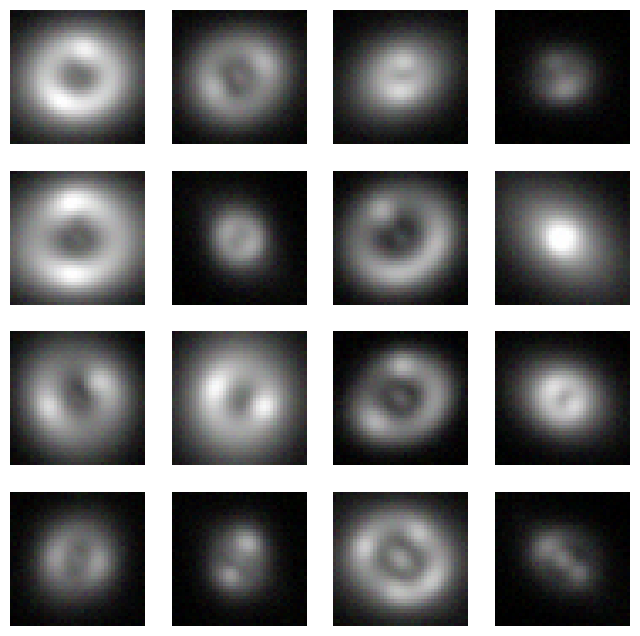

In [3]:
# Visualize source data
visualize_data(source_data)

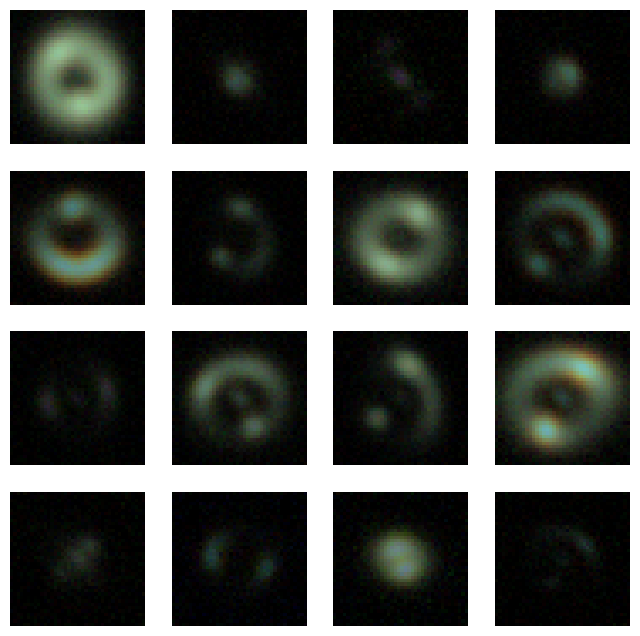

In [4]:
# Visualize target data
visualize_data(target_data)

In [5]:
model = NeuralNetwork().cuda()
learning_rate = 6e-5
epochs = 30
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[]}

print("Beginning Training...")
# Train
for i in range(epochs):
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])

        print_epoch_scores(stats, i, time.time() - start_time)
        

mod_name = "models/mb_isomap_jul18_6pm"
torch.save(model.state_dict(), mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [7]:
mod_name = "models/mb_isomap_jul18_6pm"
model.load_state_dict(torch.load("models/mb_isomap_jul18_6pm"))
stats = json.load(open(mod_name+'.json', 'r'))

In [8]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

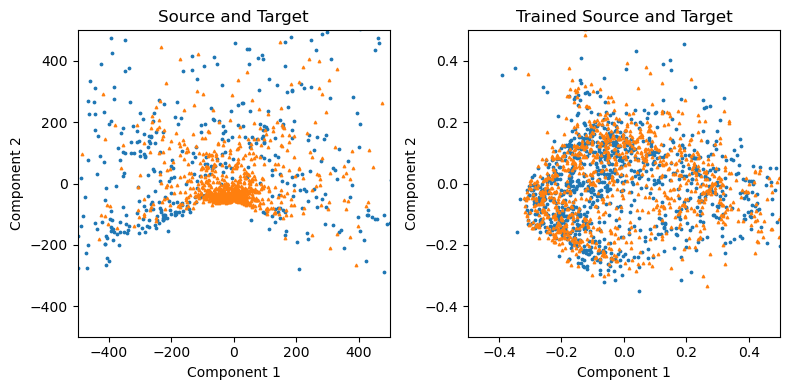

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
lval1 = 500
ax1.set_xlim(-lval1, lval1)
ax1.set_ylim(-lval1, lval1)
ax1.set_title('Source and Target')

ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
lval2 = 0.5
ax2.set_xlim(-lval2, lval2)
ax2.set_ylim(-lval2, lval2)
ax2.set_title('Trained Source and Target')

ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

plt.tight_layout()
plt.show()

In [23]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

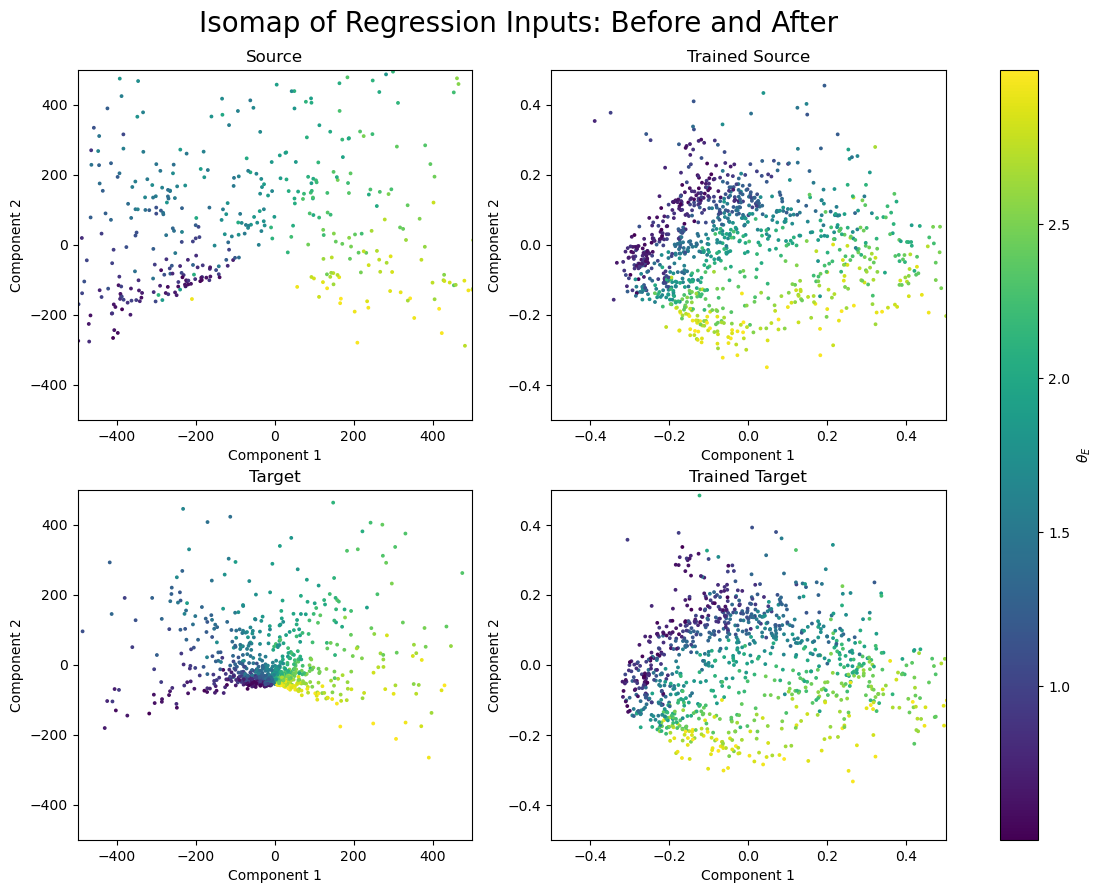

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax1 = ax[0][1]
scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
lval1 = 0.5
ax1.set_xlim(-lval1, lval1)
ax1.set_ylim(-lval1, lval1)
ax1.set_title('Trained Source')

ax2 = ax[0][0]
ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
lval2 = 500
ax2.set_xlim(-lval2, lval2)
ax2.set_ylim(-lval2, lval2)
ax2.set_title('Source')

ax1 = ax[1][1]
ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
lval1 = 0.5
ax1.set_xlim(-lval1, lval1)
ax1.set_ylim(-lval1, lval1)
ax1.set_title('Trained Target')

ax2 = ax[1][0]
ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
lval2 = 500
ax2.set_xlim(-lval2, lval2)
ax2.set_ylim(-lval2, lval2)
ax2.set_title('Target')

for i in ax.ravel():
    i.set_xlabel('Component 1')
    i.set_ylabel('Component 2')

cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
cbar.set_label('$\\theta_E$')

plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
plt.show()

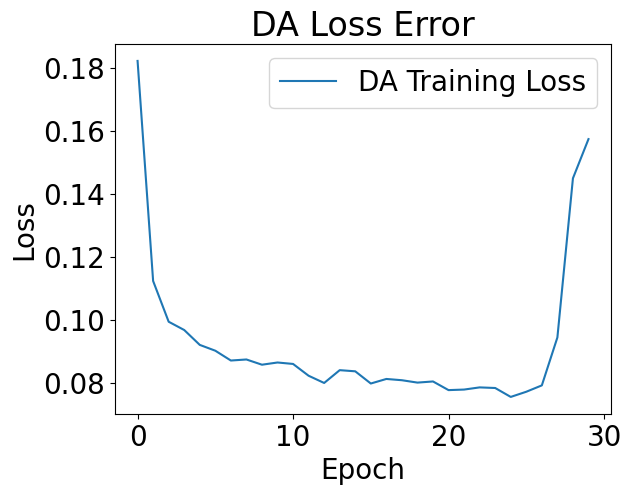

In [40]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(epochs)
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

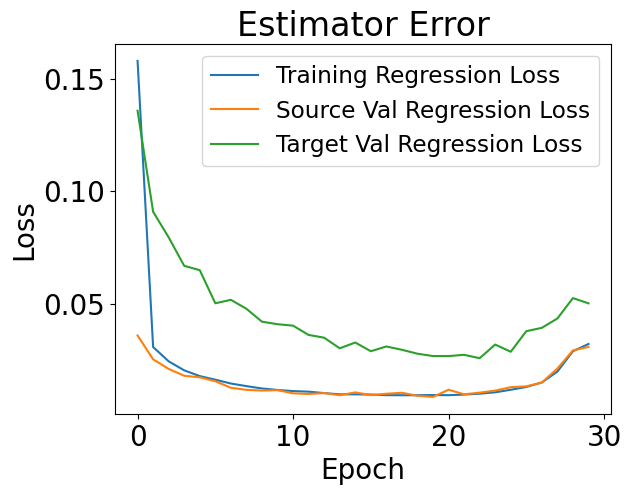

In [41]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

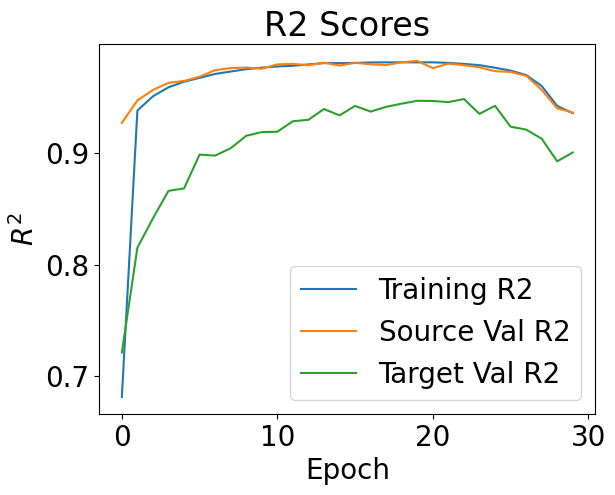

In [42]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.9368


Text(0.5, 1.0, 'MMD | Source | R2: 0.937')

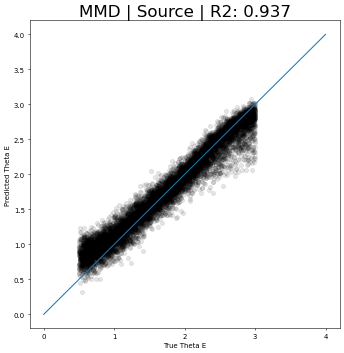

In [29]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.8984


Text(0.5, 1.0, 'MMD | Target | R2: 0.898')

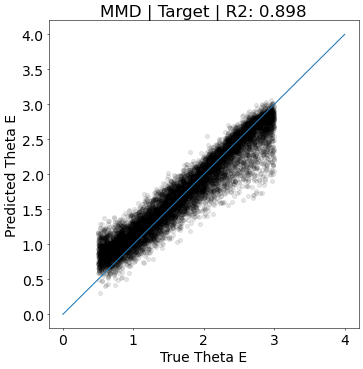

In [30]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))